### **4.2 Implémentation**
#### 4.2.1 Importation des modules

In [1]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

#### 4.2.2  Constantes pour l'algorithme génétique

In [2]:
# Constants
POPULATION_SIZE = 1000
NUM_GENERATIONS = 100
CITY_COUNT = 30
num_objects_per_city = 2
TRUCK_COUNT = 5
Mutation_probability = 0.02
truck_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']  # Colors for each truck

#### 4.2.3 Génération des données aléatoires

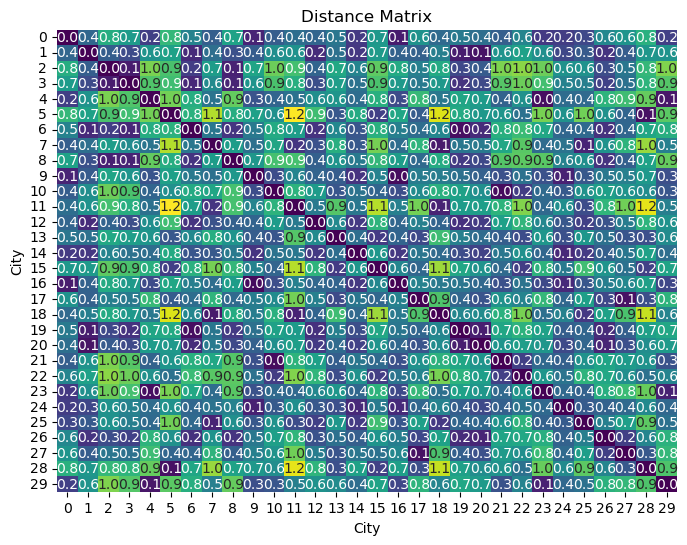

In [3]:
# Generate random city coordinates
city_coordinates = {i: tuple(coord) for i, coord in enumerate(np.random.rand(CITY_COUNT + 1, 2))}  # Dictionary: city index -> (x, y) coordinates

# Create distance matrix
distance_matrix = {}  # Dictionary: (city1, city2) -> distance
for i in range(1, CITY_COUNT + 1):
    for j in range(1, CITY_COUNT + 1):
        distance_matrix[(i, j)] = np.linalg.norm(np.array(city_coordinates[i]) - np.array(city_coordinates[j]))

# Create a matrix of distances from the distance dictionary
A = np.zeros((CITY_COUNT, CITY_COUNT))
for i in range(1, CITY_COUNT + 1):
    for j in range(1, CITY_COUNT + 1):
        A[i - 1, j - 1] = distance_matrix[(i, j)]

plt.figure(figsize=(8, 6))
sns.heatmap(A, annot=True, cmap='viridis', fmt='.1f', cbar=False)
plt.title('Distance Matrix')
plt.xlabel('City')
plt.ylabel('City')
plt.show()

In [4]:
# Génération aléatoire des distances entre les villes
distances = [[0 for j in range(CITY_COUNT)] for i in range(CITY_COUNT)]
for i in range(CITY_COUNT):
    for j in range(i + 1, CITY_COUNT):
        distance = random.randint(1, 100)
        distances[i][j] = distance
        distances[j][i] = distance

In [5]:
# Génération aléatoire des capacités des camions
truck_capacities = []
for i in range(TRUCK_COUNT):
    truck_capacity_weight = random.randint(500, 2000)  # Capacité en poids
    truck_capacity_volume = random.randint(5, 15)  # Capacité en volume
    truck_capacities.append((truck_capacity_weight, truck_capacity_volume))

In [6]:
# Génération aléatoire des caractéristiques d'encombrement pour chaque objet
object_weights = [[0 for j in range(num_objects_per_city)] for i in range(CITY_COUNT)]
object_volumes = [[0 for j in range(num_objects_per_city)] for i in range(CITY_COUNT)]
for i in range(CITY_COUNT):
    for j in range(num_objects_per_city):
        object_weight = random.randint(1, min(10, max(truck_capacities, key=lambda x: x[0])[0]))
        object_volume = random.randint(1, min(5, max(truck_capacities, key=lambda x: x[1])[1]))
        object_weights[i][j] = object_weight
        object_volumes[i][j] = object_volume

In [7]:
# Définition des contraintes d'affectation pour chaque objet
object_truck_constraints = [[[] for j in range(num_objects_per_city)] for i in range(CITY_COUNT)]
for i in range(CITY_COUNT):
    for j in range(num_objects_per_city):
        # On suppose que chaque objet peut être livré par tous les camions
        object_truck_constraints[i][j] = [k for k in range(TRUCK_COUNT)]

        # On ajoute une contrainte aléatoire pour chaque objet
        if random.random() < 0.5:
            # L'objet ne peut être livré que par certains camions
            restricted_trucks = random.sample(object_truck_constraints[i][j], random.randint(1, TRUCK_COUNT - 1))
            object_truck_constraints[i][j] = restricted_trucks

In [8]:
# Définition des contraintes d'affectation pour chaque camion
truck_object_constraints = [[] for i in range(TRUCK_COUNT)]
for i in range(TRUCK_COUNT):
    # On suppose que chaque camion peut livrer tous les objets
    truck_object_constraints[i] = [j for j in range(CITY_COUNT * num_objects_per_city)]

    # On ajoute une contrainte aléatoire pour chaque camion
    if random.random() < 0.5:
        # Le camion ne peut livrer que certains objets
        restricted_objects = random.sample(truck_object_constraints[i], random.randint(1, CITY_COUNT * num_objects_per_city - 1))
        truck_object_constraints[i] = restricted_objects

In [9]:
# Définition des contraintes d'affectation spécifiques pour chaque camion
for i in range(TRUCK_COUNT):
    # On ajoute une contrainte aléatoire pour chaque camion
    if random.random() < 0.5:
        # Le camion ne peut être utilisé que dans certaines villes
        restricted_cities = random.sample(range(CITY_COUNT), random.randint(1, CITY_COUNT - 1))
        restricted_objects = []
        for j in range(num_objects_per_city):
            if any(i in object_truck_constraints[k][j] for k in restricted_cities):
                restricted_objects.append(j + num_objects_per_city * i)
        truck_object_constraints[i] = restricted_objects

In [10]:
# Définition des contraintes d'affectation spécifiques pour chaque objet
for i in range(CITY_COUNT):
    for j in range(num_objects_per_city):
        # On ajoute une contrainte aléatoire pour chaque objet
        if random.random() < 0.5:
            # L'objet ne peut être livré que dans certaines villes
            restricted_cities = random.sample(range(CITY_COUNT), random.randint(1, CITY_COUNT - 1))
            restricted_trucks = []
            for k in range(TRUCK_COUNT):
                if k in object_truck_constraints[i][j]:
                    restricted_trucks.append(k)
            restricted_objects = []
            for k in range(num_objects_per_city):
                if k != j and any(k in object_truck_constraints[l][m] for l in restricted_cities for m in range(num_objects_per_city)):
                    restricted_objects.append(k + num_objects_per_city * i)
            object_truck_constraints[i][j] = restricted_trucks
            truck_object_constraints[restricted_trucks[0]] = [k for k in truck_object_constraints[restricted_trucks[0]] if k not in restricted_objects]


In [11]:
# Affichage des données générées aléatoirement
print("Distances entre les villes :")
for i in range(CITY_COUNT):
    print(distances[i])
print("Capacité des camions :")
for i in range(TRUCK_COUNT):
    print("Camion", i, "Capacité en poids :", truck_capacities[i][0], "Capacité en volume :", truck_capacities[i][1])
print("Caractéristiques d'encombrement des objets :")
for i in range(CITY_COUNT):
    for j in range(num_objects_per_city):
        print("Objet", j, "de la ville", i, " - Poids :", object_weights[i][j], "Volume :", object_volumes[i][j])
print("Contraintes d'affectation des objets aux camions :")
for i in range(CITY_COUNT):
    for j in range(num_objects_per_city):
        print("Objet", j, "de la ville", i, " - Camions possibles :", object_truck_constraints[i][j])
print("Contraintes d'affectation des camions aux objets :")
for i in range(TRUCK_COUNT):
    print("Camion", i, " - Objets possibles :", truck_object_constraints[i])

Distances entre les villes :
[0, 37, 52, 5, 79, 26, 75, 5, 19, 10, 40, 63, 42, 52, 96, 84, 8, 71, 44, 32, 78, 85, 22, 83, 89, 1, 81, 39, 18, 83]
[37, 0, 55, 75, 51, 78, 84, 54, 83, 89, 61, 44, 26, 2, 71, 99, 7, 75, 47, 26, 54, 51, 26, 82, 66, 56, 70, 34, 32, 41]
[52, 55, 0, 95, 20, 89, 64, 77, 94, 30, 59, 47, 82, 33, 37, 31, 75, 66, 42, 23, 26, 66, 1, 89, 94, 8, 70, 18, 21, 83]
[5, 75, 95, 0, 6, 10, 42, 31, 1, 19, 43, 45, 46, 27, 25, 20, 99, 69, 37, 56, 36, 85, 93, 33, 46, 81, 64, 10, 59, 23]
[79, 51, 20, 6, 0, 49, 45, 71, 100, 26, 16, 19, 81, 78, 2, 65, 54, 32, 34, 12, 86, 38, 18, 88, 1, 89, 83, 84, 70, 39]
[26, 78, 89, 10, 49, 0, 11, 42, 5, 96, 4, 35, 62, 90, 65, 63, 12, 45, 67, 10, 58, 71, 15, 92, 54, 90, 96, 67, 81, 36]
[75, 84, 64, 42, 45, 11, 0, 93, 14, 91, 95, 90, 85, 55, 45, 83, 49, 83, 90, 43, 32, 42, 88, 96, 44, 73, 63, 29, 31, 10]
[5, 54, 77, 31, 71, 42, 93, 0, 93, 7, 9, 64, 100, 83, 48, 3, 68, 87, 55, 11, 57, 98, 49, 96, 77, 57, 24, 40, 90, 59]
[19, 83, 94, 1, 100, 5, 14, 9

#### 4.2.4 Creation de la population initiale

In [12]:
# Create initial population
def create_initial_population():
    population = []
    for _ in range(POPULATION_SIZE):
        route = tuple(np.random.permutation(range(1, CITY_COUNT + 1)))  # Tuple: ordered sequence of city indices
        population.append(route)
    return population

#### 4.2.5 Calcul du fitness de chaque route

In [13]:
# Calculate fitness of each route in the population
def calculate_fitness(population):
    fitness_scores = []
    for route in population:
        total_distance = 0
        for i in range(len(route) - 1):
            current_city = route[i]
            next_city = route[i + 1]
            total_distance += distances[current_city - 1][next_city - 1]
        fitness_scores.append(1 / total_distance)  # Inverse of distance as fitness score
    return fitness_scores


#### 4.2.6 Selection

In [14]:
# Perform selection based on fitness scores
def selection(population, fitness_scores):
    selected_indices = np.random.choice(range(len(population)), size=POPULATION_SIZE, replace=True, p=(fitness_scores / np.sum(fitness_scores)))
    return [population[idx] for idx in selected_indices]

#### 4.2.7 Croisement

In [15]:
# Perform crossover between two parent routes
def crossover(parent1, parent2):
    child = np.zeros_like(parent1)  # Numpy array: array-like container for the child route
    start_idx = random.randint(0, len(parent1) - 2)
    end_idx = random.randint(start_idx + 1, len(parent1) - 1)
    child[start_idx:end_idx] = parent1[start_idx:end_idx]
    remaining_cities = np.setdiff1d(parent2, child)
    child[end_idx:] = remaining_cities[:len(child) - end_idx]
    child[:start_idx] = remaining_cities[len(child) - end_idx:]
    return child

#### 4.2.7 Mutation

In [16]:
# Perform mutation on a route
def mutate(route):
    idx1, idx2 = random.sample(range(1, len(route) - 1), 2)
    route = list(route)  # Convert tuple to list for mutation
    route[idx1], route[idx2] = route[idx2], route[idx1]
    return tuple(route)  # Convert list back to tuple

In [17]:
# Create next generation using selection and crossover
def create_next_generation(population, fitness_scores):
    selected_population = selection(population, fitness_scores)
    next_generation = []
    for _ in range(POPULATION_SIZE):
        parent1, parent2 = random.sample(selected_population, 2)
        child = crossover(parent1, parent2)
        next_generation.append(child)
    return next_generation

In [18]:
# Perform mutation on the population
def mutate_population(population):
    for i in range(POPULATION_SIZE):
        if random.random() < Mutation_probability:  # Mutation probability
            population[i] = mutate(population[i])
    return population

#### 4.2.8 Execution de l'algorithme génétique

In [19]:
# Run the genetic algorithm
def run_genetic_algorithm():
    population = create_initial_population()
    fitness_progress = []
    start_time = time.time()
    for generation in range(NUM_GENERATIONS):
        fitness_scores = calculate_fitness(population)
        best_fitness = max(fitness_scores)
        best_route = population[fitness_scores.index(best_fitness)]
        fitness_progress.append(best_fitness)
        population = create_next_generation(population, fitness_scores)
        population = mutate_population(population)
        print(f"Generation {generation + 1}: Best Distance = {1 / best_fitness}")
    end_time = time.time()

    # Print the best route
    print("\nBest Route:")
    print(np.concatenate(([0], best_route, [0])))
    
# Create and plot the graph using NetworkX
    G = nx.Graph()
    G.add_nodes_from(range(1, CITY_COUNT + 1))

    pos = nx.spring_layout(G)  # Positions of the cities
    nx.draw_networkx_nodes(G, pos, node_color='r', node_size=200)
    nx.draw_networkx_labels(G, pos, font_color='w', font_size=10)

    best_route_edges = [(best_route[i], best_route[i + 1]) for i in range(len(best_route) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=best_route_edges, edge_color='g', width=2)
    plt.axis('off')
    plt.show()
    
 # Generate paths for each truck
    truck_paths = []
    for truck in range(TRUCK_COUNT):
        truck_path = np.concatenate(([0], best_route[truck * (CITY_COUNT // TRUCK_COUNT):(truck + 1) * (CITY_COUNT // TRUCK_COUNT)], [0]))
        truck_paths.append(truck_path)
        print(f"\nTruck {truck + 1} Path:")
        print(truck_path)
 # Plot fitness progress
    plt.plot(fitness_progress)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.title('Genetic Algorithm - Fitness Progress')
    plt.show()
    
 # Print execution time
    print(f"\nExecution Time: {end_time - start_time} seconds")
    
 # Plot the truck paths
    for truck, path in enumerate(truck_paths):
        path_coordinates = np.array([city_coordinates[i] for i in path])
        plt.plot(path_coordinates[:, 0], path_coordinates[:, 1], '-o', color=truck_colors[truck], label=f"Truck {truck + 1} Path")
    plt.plot(city_coordinates[0][0], city_coordinates[0][1], 'ro', color="black", label='Depot')
    plt.legend()
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Truck Paths')
    plt.show()

Generation 1: Best Distance = 946.0
Generation 2: Best Distance = 1040.0
Generation 3: Best Distance = 1148.0
Generation 4: Best Distance = 1067.0
Generation 5: Best Distance = 1218.0
Generation 6: Best Distance = 1218.0
Generation 7: Best Distance = 1247.0
Generation 8: Best Distance = 1278.0
Generation 9: Best Distance = 1278.0
Generation 10: Best Distance = 1316.0
Generation 11: Best Distance = 1209.0
Generation 12: Best Distance = 1270.0
Generation 13: Best Distance = 1249.0
Generation 14: Best Distance = 1322.0
Generation 15: Best Distance = 1297.0
Generation 16: Best Distance = 1285.0
Generation 17: Best Distance = 1285.0
Generation 18: Best Distance = 1238.0
Generation 19: Best Distance = 1238.0
Generation 20: Best Distance = 1238.0
Generation 21: Best Distance = 1271.0
Generation 22: Best Distance = 1275.0
Generation 23: Best Distance = 1215.0
Generation 24: Best Distance = 1297.0
Generation 25: Best Distance = 1318.0
Generation 26: Best Distance = 1335.0
Generation 27: Best Di

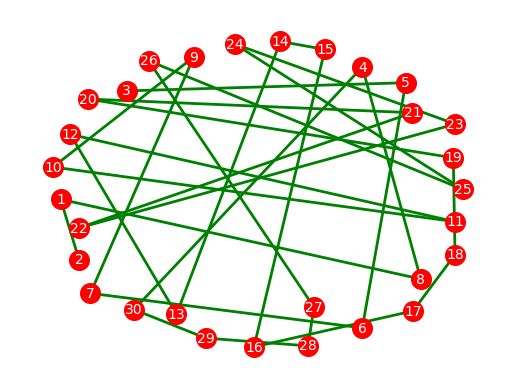


Truck 1 Path:
[ 0  3  5  6  7  9 10  0]

Truck 2 Path:
[ 0 11 12 13 14 15 16  0]

Truck 3 Path:
[ 0 17 18 19 20 21 22  0]

Truck 4 Path:
[ 0 23 24 25 26 27 28  0]

Truck 5 Path:
[ 0 29 30  4  8  1  2  0]


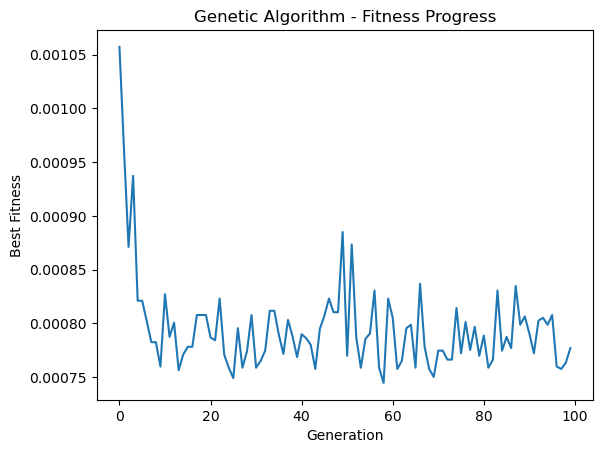


Execution Time: 21.47442102432251 seconds


C:\Users\Acer\AppData\Local\Temp\ipykernel_16708\2394890234.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(city_coordinates[0][0], city_coordinates[0][1], 'ro', color="black", label='Depot')


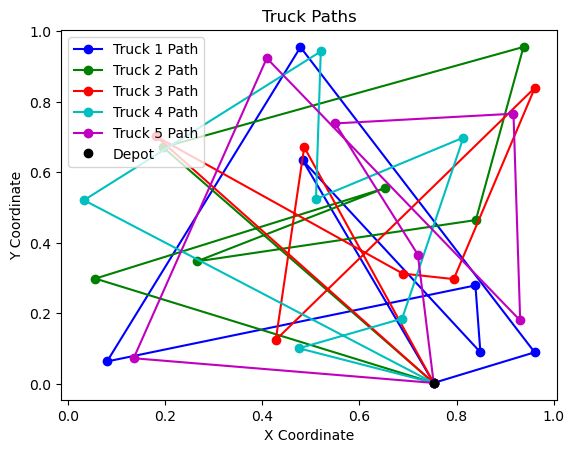

In [20]:
# Run the genetic algorithm
run_genetic_algorithm()

In [21]:
# Create a list to store execution times
execution_times = []

Generation 1: Best Distance = 979.9999999999999
Generation 2: Best Distance = 1081.0
Generation 3: Best Distance = 1115.0
Generation 4: Best Distance = 1142.0
Generation 5: Best Distance = 1168.0
Generation 6: Best Distance = 1199.0
Generation 7: Best Distance = 1199.0
Generation 8: Best Distance = 1273.0
Generation 9: Best Distance = 1320.0
Generation 10: Best Distance = 1281.0
Generation 11: Best Distance = 1273.0
Generation 12: Best Distance = 1193.0
Generation 13: Best Distance = 1320.0
Generation 14: Best Distance = 1310.0
Generation 15: Best Distance = 1288.0
Generation 16: Best Distance = 1315.0
Generation 17: Best Distance = 1291.0
Generation 18: Best Distance = 1322.0
Generation 19: Best Distance = 1322.0
Generation 20: Best Distance = 1262.0
Generation 21: Best Distance = 1270.0
Generation 22: Best Distance = 1201.0
Generation 23: Best Distance = 1248.0
Generation 24: Best Distance = 1244.0
Generation 25: Best Distance = 1263.0
Generation 26: Best Distance = 1259.0
Generation

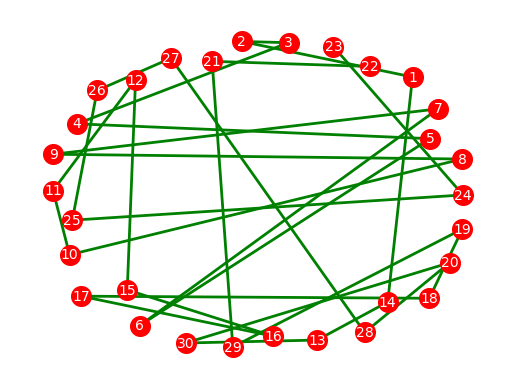


Truck 1 Path:
[ 0 23 24 25 26 27 28  0]

Truck 2 Path:
[ 0 20 30 13 14  1  2  0]

Truck 3 Path:
[0 3 4 5 6 7 9 0]

Truck 4 Path:
[ 0  8 10 11 12 15 16  0]

Truck 5 Path:
[ 0 17 18 19 29 21 22  0]


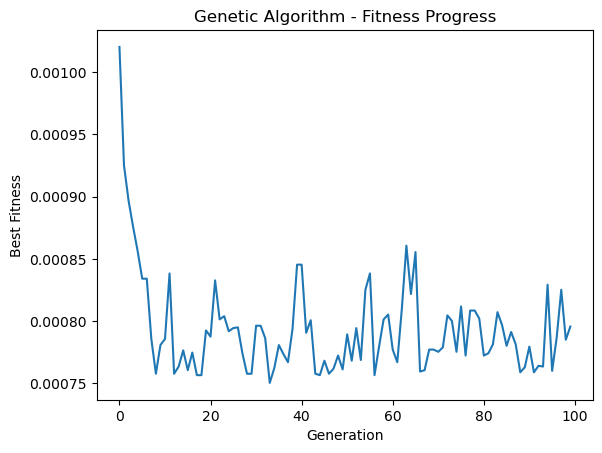


Execution Time: 24.169785261154175 seconds


C:\Users\Acer\AppData\Local\Temp\ipykernel_16708\2394890234.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(city_coordinates[0][0], city_coordinates[0][1], 'ro', color="black", label='Depot')


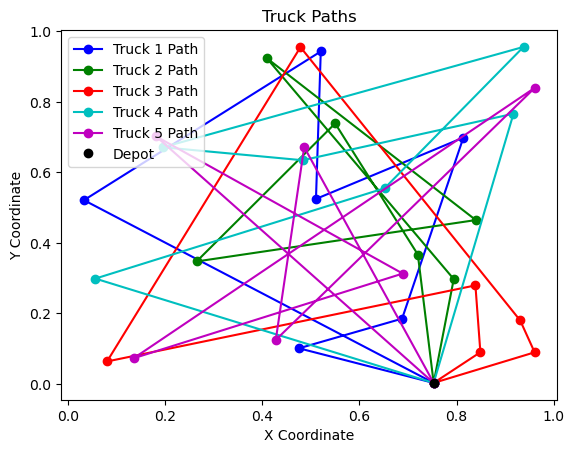

Generation 1: Best Distance = 1003.0000000000001
Generation 2: Best Distance = 994.9999999999999
Generation 3: Best Distance = 1129.0
Generation 4: Best Distance = 1036.0
Generation 5: Best Distance = 1265.0
Generation 6: Best Distance = 1236.0
Generation 7: Best Distance = 1182.0
Generation 8: Best Distance = 1318.0
Generation 9: Best Distance = 1287.0
Generation 10: Best Distance = 1294.0
Generation 11: Best Distance = 1311.0
Generation 12: Best Distance = 1287.0
Generation 13: Best Distance = 1218.0
Generation 14: Best Distance = 1207.0
Generation 15: Best Distance = 1207.0
Generation 16: Best Distance = 1266.0
Generation 17: Best Distance = 1249.0
Generation 18: Best Distance = 1318.0
Generation 19: Best Distance = 1311.0
Generation 20: Best Distance = 1321.0
Generation 21: Best Distance = 1222.0
Generation 22: Best Distance = 1222.0
Generation 23: Best Distance = 1200.0
Generation 24: Best Distance = 1297.0
Generation 25: Best Distance = 1318.0
Generation 26: Best Distance = 1315.

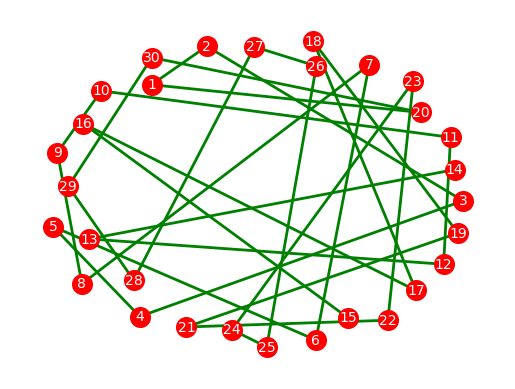


Truck 1 Path:
[ 0 15 16 17 18 19 21  0]

Truck 2 Path:
[ 0 22 23 24 25 26 27  0]

Truck 3 Path:
[ 0 28 29 30 20  1  2  0]

Truck 4 Path:
[0 3 4 5 6 7 8 0]

Truck 5 Path:
[ 0  9 10 11 12 13 14  0]


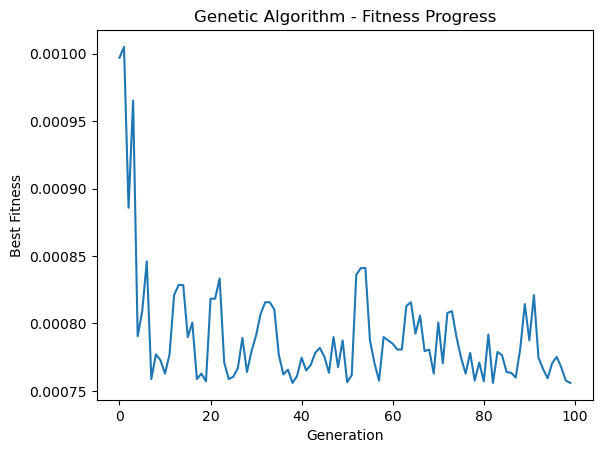


Execution Time: 24.01996636390686 seconds


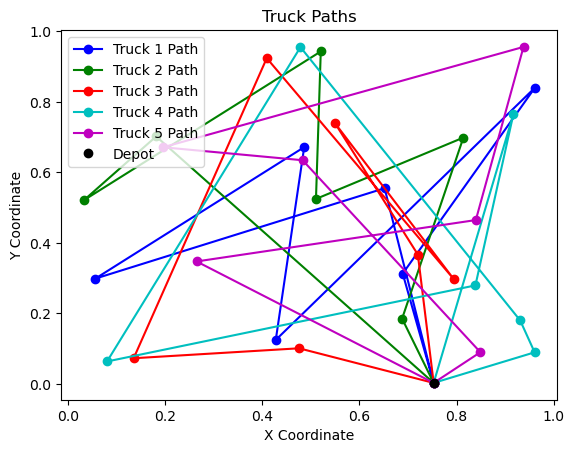

Generation 1: Best Distance = 1055.0
Generation 2: Best Distance = 1009.0
Generation 3: Best Distance = 1009.0
Generation 4: Best Distance = 1149.0
Generation 5: Best Distance = 1182.0
Generation 6: Best Distance = 1247.0
Generation 7: Best Distance = 1261.0
Generation 8: Best Distance = 1237.0
Generation 9: Best Distance = 1192.0
Generation 10: Best Distance = 1298.0
Generation 11: Best Distance = 1179.0
Generation 12: Best Distance = 1230.0
Generation 13: Best Distance = 1272.0
Generation 14: Best Distance = 1303.0
Generation 15: Best Distance = 1262.0
Generation 16: Best Distance = 1243.0
Generation 17: Best Distance = 1274.0
Generation 18: Best Distance = 1251.0
Generation 19: Best Distance = 1251.0
Generation 20: Best Distance = 1290.0
Generation 21: Best Distance = 1319.0
Generation 22: Best Distance = 1320.0
Generation 23: Best Distance = 1264.0
Generation 24: Best Distance = 1275.0
Generation 25: Best Distance = 1320.0
Generation 26: Best Distance = 1319.0
Generation 27: Best D

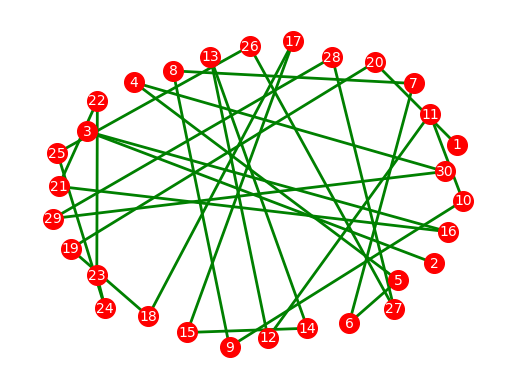


Truck 1 Path:
[ 0  2  3 16 21 22 23  0]

Truck 2 Path:
[ 0 24 25 26 27 28 29  0]

Truck 3 Path:
[ 0 30  4  5  6  7  8  0]

Truck 4 Path:
[ 0  9 10 11 12 13 14  0]

Truck 5 Path:
[ 0 15 17 18 19 20  1  0]


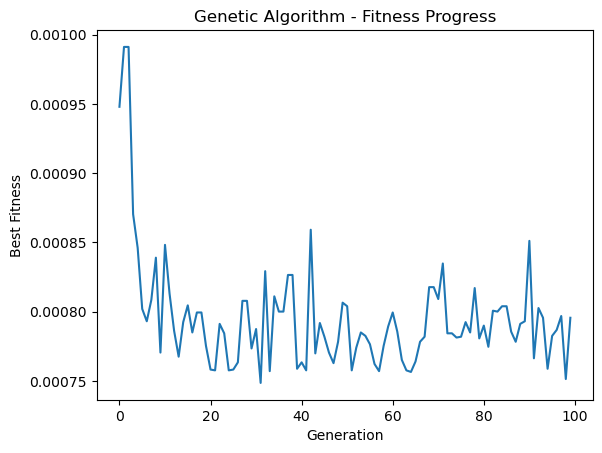


Execution Time: 23.660091161727905 seconds


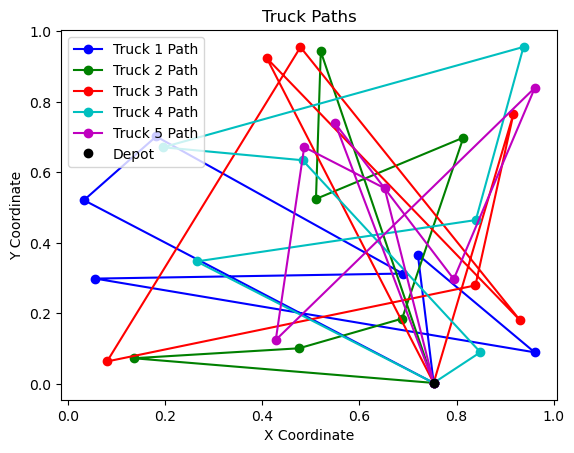

Generation 1: Best Distance = 1066.0
Generation 2: Best Distance = 1109.0
Generation 3: Best Distance = 1080.0
Generation 4: Best Distance = 1069.0
Generation 5: Best Distance = 1221.0
Generation 6: Best Distance = 1234.0
Generation 7: Best Distance = 1318.0
Generation 8: Best Distance = 1279.0
Generation 9: Best Distance = 1312.0
Generation 10: Best Distance = 1257.0
Generation 11: Best Distance = 1259.0
Generation 12: Best Distance = 1217.0
Generation 13: Best Distance = 1188.0
Generation 14: Best Distance = 1297.0
Generation 15: Best Distance = 1297.0
Generation 16: Best Distance = 1256.0
Generation 17: Best Distance = 1320.0
Generation 18: Best Distance = 1302.0
Generation 19: Best Distance = 1313.0
Generation 20: Best Distance = 1320.0
Generation 21: Best Distance = 1207.0
Generation 22: Best Distance = 1272.0
Generation 23: Best Distance = 1278.0
Generation 24: Best Distance = 1320.0
Generation 25: Best Distance = 1282.0
Generation 26: Best Distance = 1303.0
Generation 27: Best D

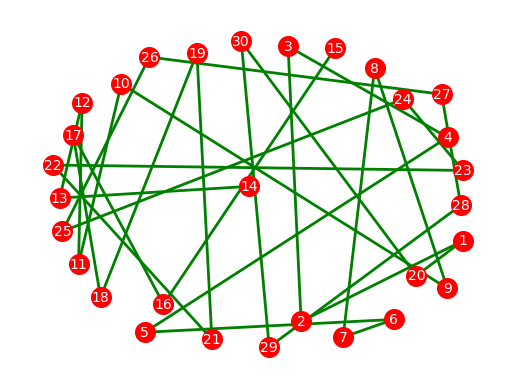


Truck 1 Path:
[ 0 15 16 17 18 19 21  0]

Truck 2 Path:
[ 0 22 23 24 25 26 27  0]

Truck 3 Path:
[ 0 28 29 30 20  1  2  0]

Truck 4 Path:
[0 3 4 5 6 7 8 0]

Truck 5 Path:
[ 0  9 10 11 12 13 14  0]


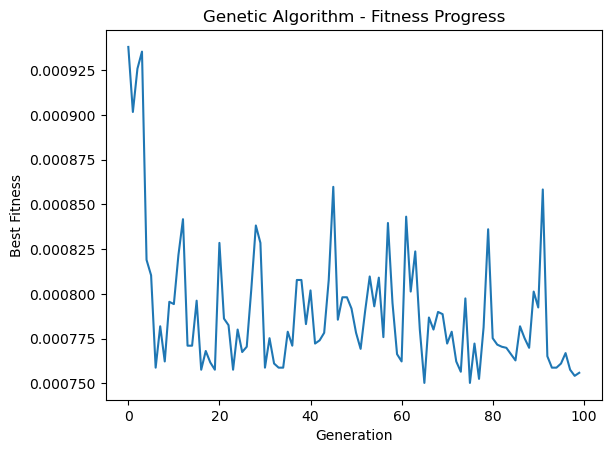


Execution Time: 23.306525468826294 seconds


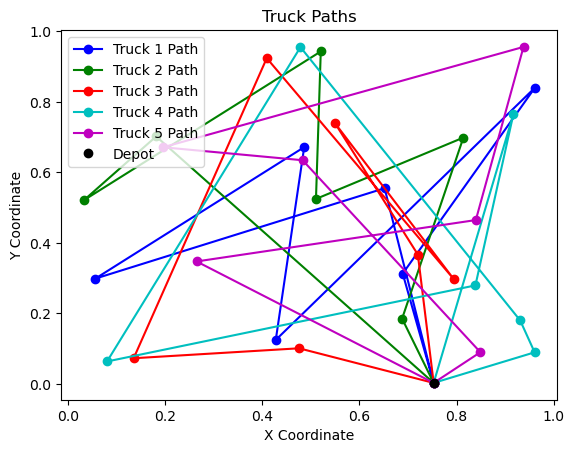

Generation 1: Best Distance = 1106.0
Generation 2: Best Distance = 1035.0
Generation 3: Best Distance = 1035.0
Generation 4: Best Distance = 1186.0
Generation 5: Best Distance = 1206.0
Generation 6: Best Distance = 1206.0
Generation 7: Best Distance = 1193.0
Generation 8: Best Distance = 1221.0
Generation 9: Best Distance = 1282.0
Generation 10: Best Distance = 1287.0
Generation 11: Best Distance = 1295.0
Generation 12: Best Distance = 1300.0
Generation 13: Best Distance = 1297.0
Generation 14: Best Distance = 1196.0
Generation 15: Best Distance = 1300.0
Generation 16: Best Distance = 1218.0
Generation 17: Best Distance = 1271.0
Generation 18: Best Distance = 1274.0
Generation 19: Best Distance = 1220.0
Generation 20: Best Distance = 1205.0
Generation 21: Best Distance = 1289.0
Generation 22: Best Distance = 1302.0
Generation 23: Best Distance = 1320.0
Generation 24: Best Distance = 1303.0
Generation 25: Best Distance = 1194.0
Generation 26: Best Distance = 1208.0
Generation 27: Best D

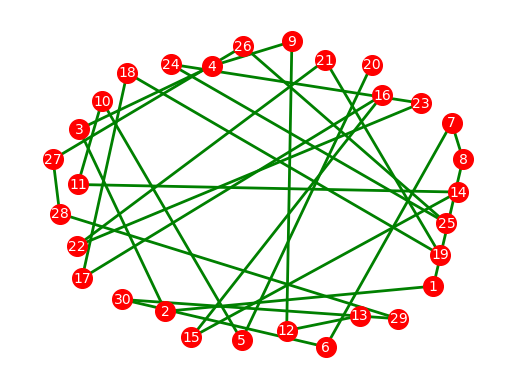


Truck 1 Path:
[ 0 20  5 10 11 14 15  0]

Truck 2 Path:
[ 0 16 17 18 19 21 22  0]

Truck 3 Path:
[ 0 23 24 25 26 27 28  0]

Truck 4 Path:
[ 0 29 30  6  7  8  1  0]

Truck 5 Path:
[ 0  2  3  4  9 12 13  0]


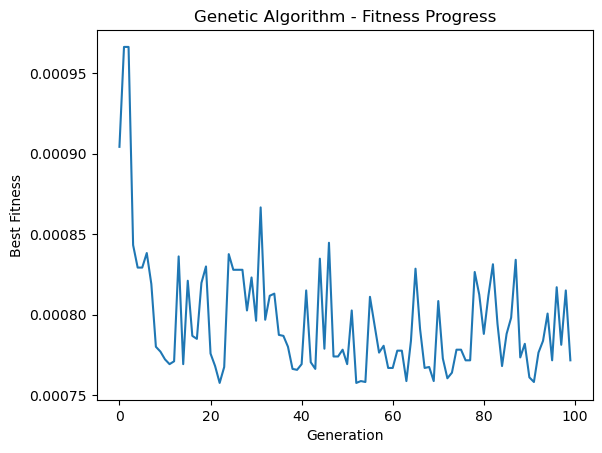


Execution Time: 23.641722917556763 seconds


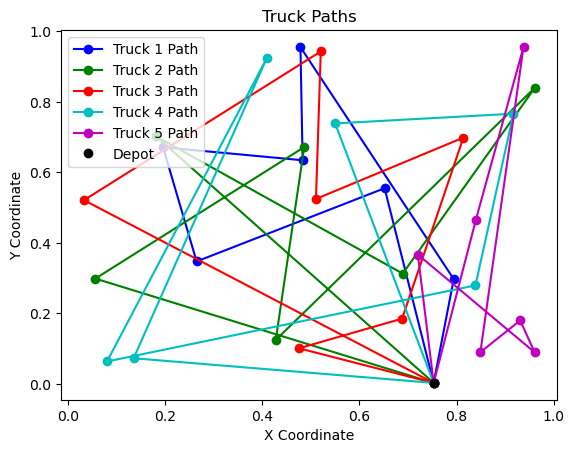

Generation 1: Best Distance = 1015.0000000000001
Generation 2: Best Distance = 1076.0
Generation 3: Best Distance = 1118.0
Generation 4: Best Distance = 1185.0
Generation 5: Best Distance = 1221.0
Generation 6: Best Distance = 1204.0
Generation 7: Best Distance = 1189.0
Generation 8: Best Distance = 1271.0
Generation 9: Best Distance = 1271.0
Generation 10: Best Distance = 1277.0
Generation 11: Best Distance = 1277.0
Generation 12: Best Distance = 1301.0
Generation 13: Best Distance = 1320.0
Generation 14: Best Distance = 1289.0
Generation 15: Best Distance = 1323.0
Generation 16: Best Distance = 1277.0
Generation 17: Best Distance = 1320.0
Generation 18: Best Distance = 1259.0
Generation 19: Best Distance = 1284.0
Generation 20: Best Distance = 1322.0
Generation 21: Best Distance = 1304.0
Generation 22: Best Distance = 1302.0
Generation 23: Best Distance = 1322.0
Generation 24: Best Distance = 1298.0
Generation 25: Best Distance = 1283.0
Generation 26: Best Distance = 1301.0
Generatio

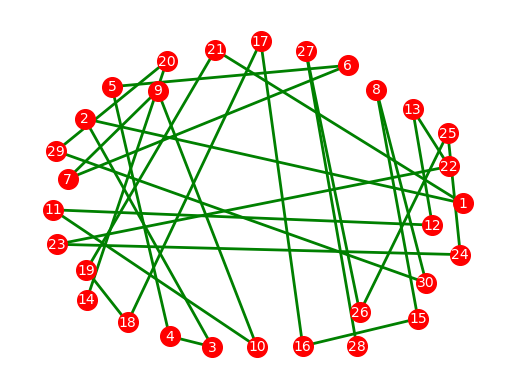


Truck 1 Path:
[ 0 14 20 29 30  8 15  0]

Truck 2 Path:
[ 0 16 17 18 19 21  1  0]

Truck 3 Path:
[0 2 3 4 5 6 7 0]

Truck 4 Path:
[ 0  9 10 11 12 13 22  0]

Truck 5 Path:
[ 0 23 24 25 26 27 28  0]


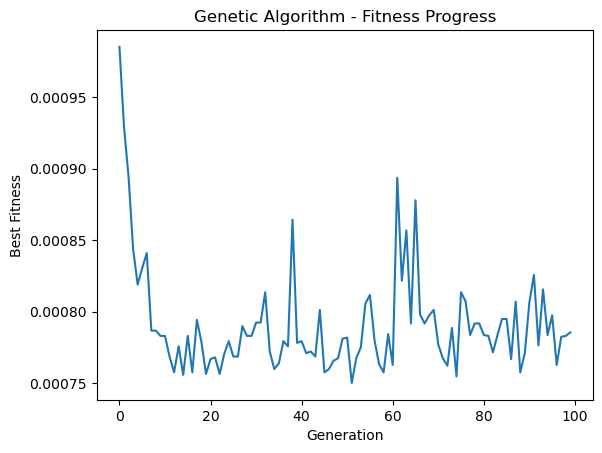


Execution Time: 24.085402250289917 seconds


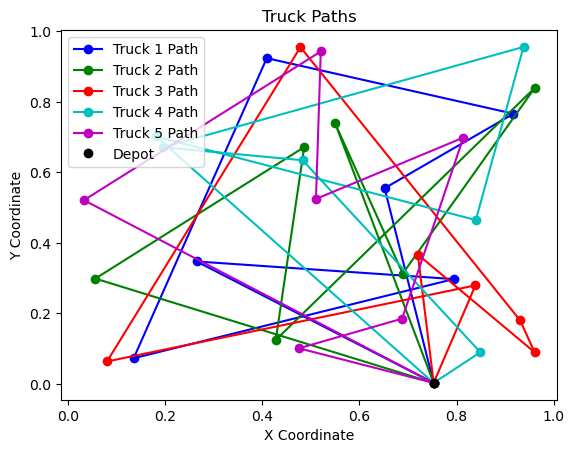

Generation 1: Best Distance = 965.9999999999999
Generation 2: Best Distance = 1059.0
Generation 3: Best Distance = 1131.0
Generation 4: Best Distance = 1184.0
Generation 5: Best Distance = 1187.0
Generation 6: Best Distance = 1224.0
Generation 7: Best Distance = 1276.0
Generation 8: Best Distance = 1278.0
Generation 9: Best Distance = 1260.0
Generation 10: Best Distance = 1272.0
Generation 11: Best Distance = 1289.0
Generation 12: Best Distance = 1288.0
Generation 13: Best Distance = 1318.0
Generation 14: Best Distance = 1261.0
Generation 15: Best Distance = 1295.0
Generation 16: Best Distance = 1263.0
Generation 17: Best Distance = 1254.0
Generation 18: Best Distance = 1244.0
Generation 19: Best Distance = 1229.0
Generation 20: Best Distance = 1302.0
Generation 21: Best Distance = 1321.0
Generation 22: Best Distance = 1320.0
Generation 23: Best Distance = 1320.0
Generation 24: Best Distance = 1309.0
Generation 25: Best Distance = 1316.0
Generation 26: Best Distance = 1291.0
Generation

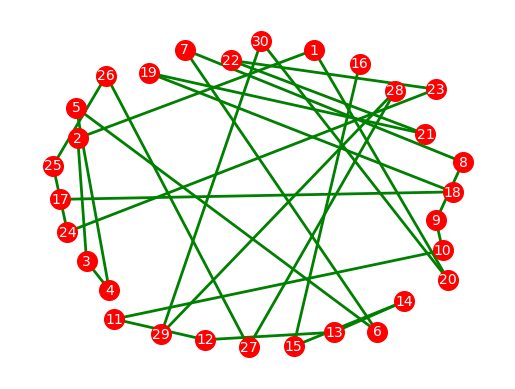


Truck 1 Path:
[ 0 17 18 19 21 22 23  0]

Truck 2 Path:
[ 0 24 25 26 27 28 29  0]

Truck 3 Path:
[ 0 30 20  1  2  3  4  0]

Truck 4 Path:
[ 0  5  6  7  8  9 10  0]

Truck 5 Path:
[ 0 11 12 13 14 15 16  0]


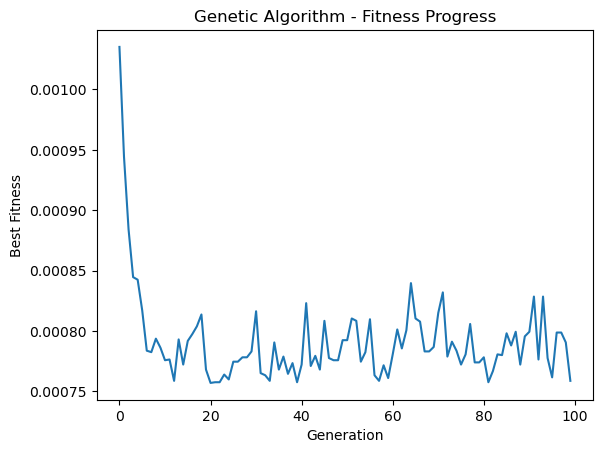


Execution Time: 23.898211002349854 seconds


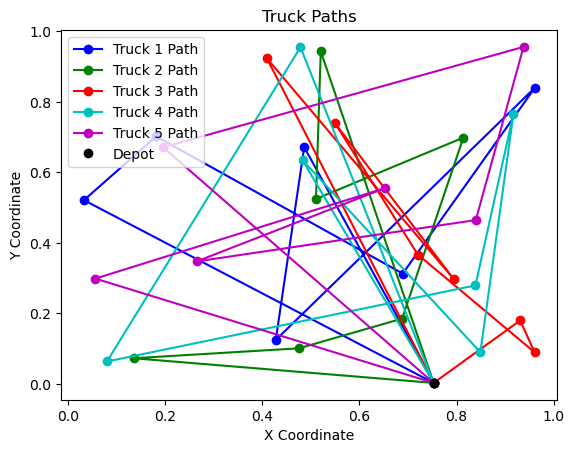

Generation 1: Best Distance = 990.0
Generation 2: Best Distance = 1072.0
Generation 3: Best Distance = 1154.0
Generation 4: Best Distance = 1213.0
Generation 5: Best Distance = 1234.0
Generation 6: Best Distance = 1234.0
Generation 7: Best Distance = 1282.0
Generation 8: Best Distance = 1278.0
Generation 9: Best Distance = 1318.0
Generation 10: Best Distance = 1290.0
Generation 11: Best Distance = 1211.0
Generation 12: Best Distance = 1183.0
Generation 13: Best Distance = 1269.0
Generation 14: Best Distance = 1303.0
Generation 15: Best Distance = 1301.0
Generation 16: Best Distance = 1296.0
Generation 17: Best Distance = 1291.0
Generation 18: Best Distance = 1263.0
Generation 19: Best Distance = 1272.0
Generation 20: Best Distance = 1279.0
Generation 21: Best Distance = 1284.0
Generation 22: Best Distance = 1172.0
Generation 23: Best Distance = 1233.0
Generation 24: Best Distance = 1286.0
Generation 25: Best Distance = 1255.0
Generation 26: Best Distance = 1313.0
Generation 27: Best Di

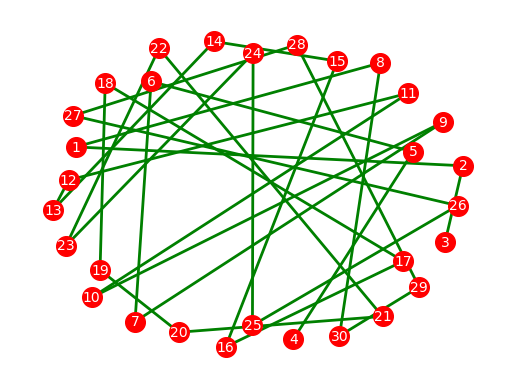


Truck 1 Path:
[ 0  4  5  6  7  9 10  0]

Truck 2 Path:
[ 0 11 12 13 14 15 16  0]

Truck 3 Path:
[ 0 17 18 19 20 21 22  0]

Truck 4 Path:
[ 0 23 24 25 26 27 28  0]

Truck 5 Path:
[ 0 29 30  8  1  2  3  0]


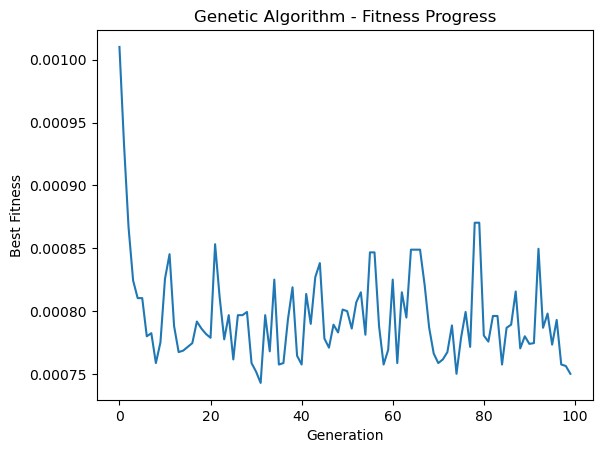


Execution Time: 13.10377550125122 seconds


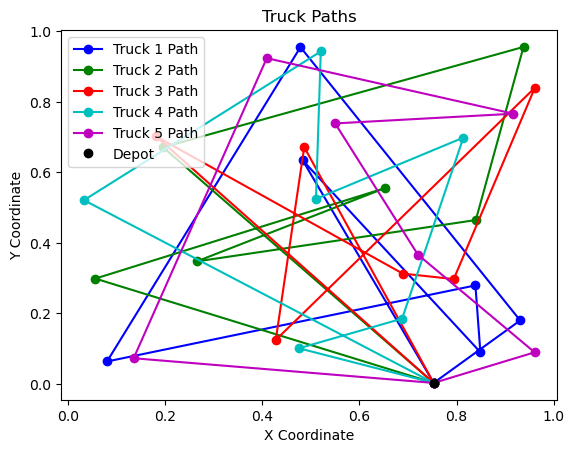

Generation 1: Best Distance = 1016.0
Generation 2: Best Distance = 860.0
Generation 3: Best Distance = 901.0
Generation 4: Best Distance = 1099.0
Generation 5: Best Distance = 1197.0
Generation 6: Best Distance = 1183.0
Generation 7: Best Distance = 1181.0
Generation 8: Best Distance = 1260.0
Generation 9: Best Distance = 1265.0
Generation 10: Best Distance = 1311.0
Generation 11: Best Distance = 1305.0
Generation 12: Best Distance = 1211.0
Generation 13: Best Distance = 1246.0
Generation 14: Best Distance = 1291.0
Generation 15: Best Distance = 1291.0
Generation 16: Best Distance = 1229.0
Generation 17: Best Distance = 1312.0
Generation 18: Best Distance = 1282.0
Generation 19: Best Distance = 1284.0
Generation 20: Best Distance = 1205.0
Generation 21: Best Distance = 1289.0
Generation 22: Best Distance = 1257.0
Generation 23: Best Distance = 1246.0
Generation 24: Best Distance = 1295.0
Generation 25: Best Distance = 1286.0
Generation 26: Best Distance = 1284.0
Generation 27: Best Dis

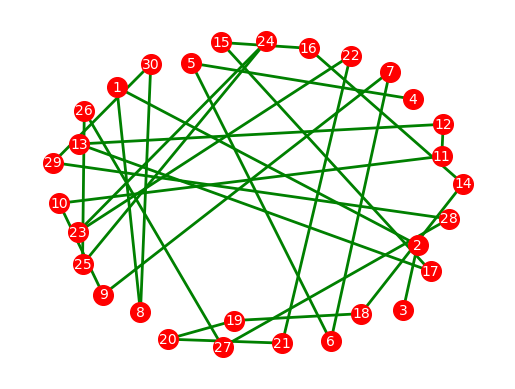


Truck 1 Path:
[ 0  4  5  6  7  9 10  0]

Truck 2 Path:
[ 0 11 12 13 17 15 16  0]

Truck 3 Path:
[ 0 14 18 19 20 21 22  0]

Truck 4 Path:
[ 0 23 24 25 26 27 28  0]

Truck 5 Path:
[ 0 29 30  8  1  2  3  0]


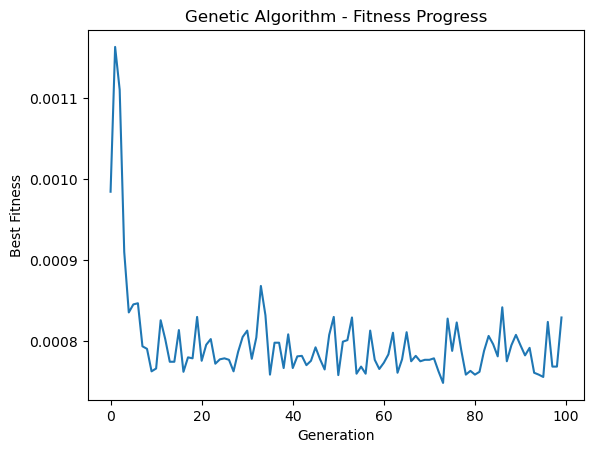


Execution Time: 6.872417688369751 seconds


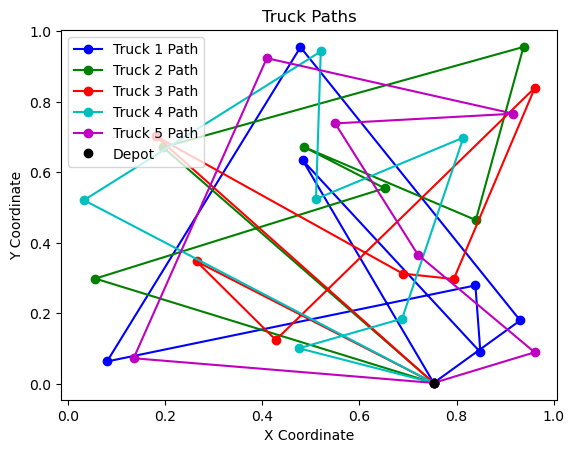

Generation 1: Best Distance = 1074.0
Generation 2: Best Distance = 1113.0
Generation 3: Best Distance = 1113.0
Generation 4: Best Distance = 1113.0
Generation 5: Best Distance = 1132.0
Generation 6: Best Distance = 1208.0
Generation 7: Best Distance = 1295.0
Generation 8: Best Distance = 1306.0
Generation 9: Best Distance = 1281.0
Generation 10: Best Distance = 1239.0
Generation 11: Best Distance = 1298.0
Generation 12: Best Distance = 1298.0
Generation 13: Best Distance = 1139.0
Generation 14: Best Distance = 1318.0
Generation 15: Best Distance = 1282.0
Generation 16: Best Distance = 1322.0
Generation 17: Best Distance = 1232.0
Generation 18: Best Distance = 1253.0
Generation 19: Best Distance = 1301.0
Generation 20: Best Distance = 1288.0
Generation 21: Best Distance = 1226.0
Generation 22: Best Distance = 1318.0
Generation 23: Best Distance = 1305.0
Generation 24: Best Distance = 1252.0
Generation 25: Best Distance = 1304.0
Generation 26: Best Distance = 1225.0
Generation 27: Best D

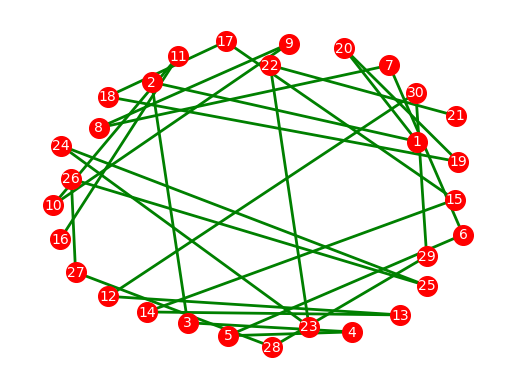


Truck 1 Path:
[ 0 21 22 23 24 25 26  0]

Truck 2 Path:
[ 0 27 28 29 30 12 13  0]

Truck 3 Path:
[ 0 14 15 17 18 19 20  0]

Truck 4 Path:
[0 1 2 3 4 5 6 0]

Truck 5 Path:
[ 0  7  8  9 10 11 16  0]


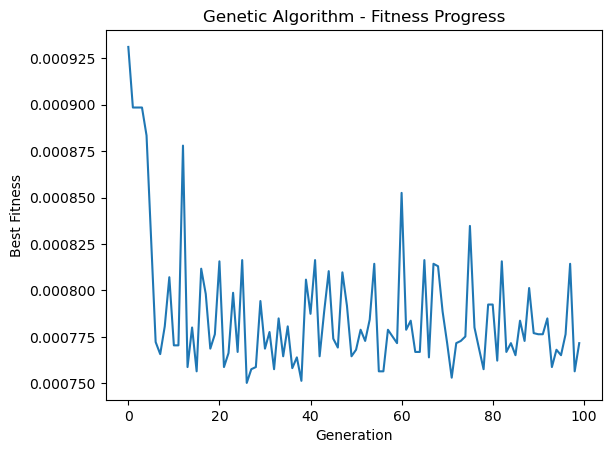


Execution Time: 6.6885597705841064 seconds


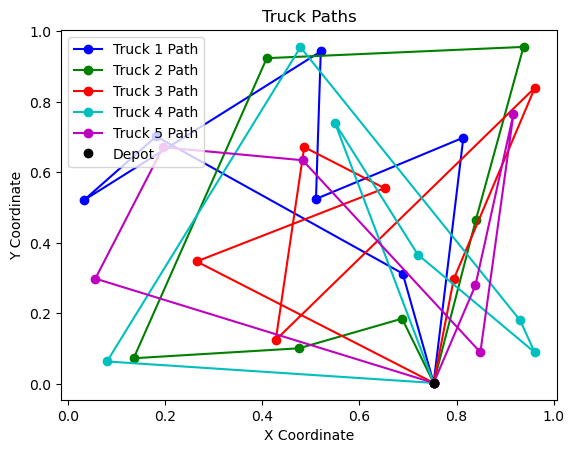

In [22]:
# Run the genetic algorithm multiple times
for _ in range(10):
    start_time = time.time()
    run_genetic_algorithm()
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time)

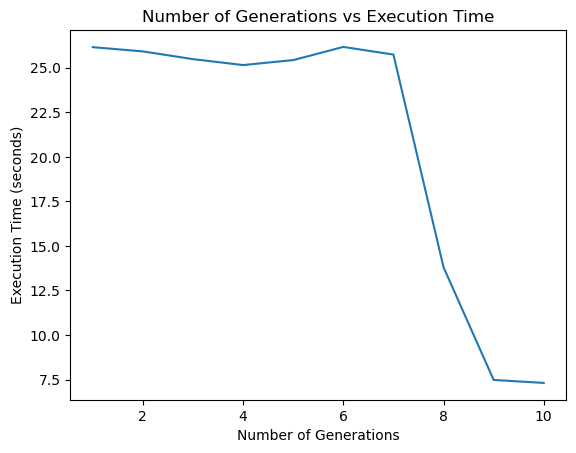

In [23]:

# Plot the number of generations vs execution time
generation_numbers = list(range(1, 11))
plt.plot(generation_numbers, execution_times)
plt.xlabel('Number of Generations')
plt.ylabel('Execution Time (seconds)')
plt.title('Number of Generations vs Execution Time')
plt.show()